# Displacements due to pressure variations in reservoir simulating a Disk-shaped reservoir under uniform depletion by using 1) a set of Geertsma's nucleus of strain  model  2) Geertsma's cylinder and 3) Nagy's method with a set of prisms

This code aims at creating the synthetic simulating a Disk-shaped reservoir under uniform depletion


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import pickle

In [2]:
import compaction as cp
import geertsma_nucleus_strain as ns
import geertsma_disk as ge

In [3]:
# Parameters describing the reservoir

R = 500. #radius of the cylinder 
top = 750. #reservoir top
bottom = 751 #reservoir bottom
h = bottom - top #reservoir thickness
D = 0.5*(bottom+top)
x0 = 0
y0 = 0

In [17]:
y_min = y0 - R
y_max = y0 + R
x_min = x0 - R
x_max = x0 + R
dy = (y_max - y_min)/20
dx = (x_max - x_min)/20

In [35]:
volume_prism = dx*dy*h

In [4]:
print('reservoir thickness:', h )

reservoir thickness: 1.0


In [5]:
# Define the model which consists of a disk-shaped reservoir 
# This model will be used by our methodology
model = cp.prism_layer_circular((0,0), R, (20,20), bottom, top)

In [12]:
# Geertsma’s nucleus of strain model  Equation 12.39 page 404 of the Book 
# Fjaer, E., et al., 2008. Petroleum Related Rock Mechanics, 2nd ed. Elsevier.
# model_ns  = [ns.nuclei_layer_circular((0,0), R, (100,100), top),
#              ns.nuclei_layer_circular((0,0), R, (100,100), top + 0.25),
#              ns.nuclei_layer_circular((0,0), R, (100,100), top + 0.50),
#              ns.nuclei_layer_circular((0,0), R, (100,100), top + 0.75),
#              ns.nuclei_layer_circular((0,0), R, (100,100), bottom)]
model_ns  = ns.nuclei_layer_circular((0,0), R, (20,20), top)

In [7]:
#model_ns = np.vstack(model_ns)

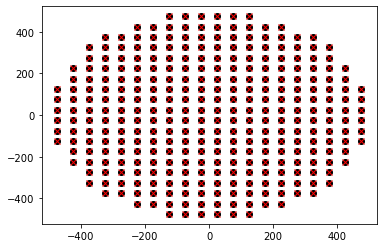

In [14]:
plt.figure()
plt.plot(0.5*(model[:,0]+model[:,1]), 
         0.5*(model[:,2]+model[:,3]), 'ko')
plt.plot(model_ns[:,0], model_ns[:,1], 'rx')
plt.show()

In [19]:
# Define the model which consists of a disk-shaped reservoir (one cylinder)
# This model will be used Geertsma's (1973) method 
# Reference: Geertsma, J.: Land Subsidence above compacting oil and gas reservoirs, J. Pet. Tech. 25, 734-744, 1973.
model_ge  = [y0, x0, D, R, h]

In [36]:
# Pressure variation (in MPa)
DP    = np.zeros(len(model)) - 10.
DP_ns = -10.*volume_prism
DP_ge = -10.

#### Young’s modulus $E$ and  Poisson's ratio $\nu$ 

In [21]:
# Young’s modulus (in MPa)
young = 3300

# Poisson coefficient
poisson = 0.25

### The uniaxial compaction coefficient $C_m$ 
$C_m = \frac{1}{E} \: \frac{(1 + \nu) (1  - 2\nu)}{(1-\nu)}$

In [22]:
cm = cp.Cm(poisson, young) # uniaxial compaction coefficient in 1/MPa
G = young/(2*(1+poisson)) # Shear Modulus in MPa
print ('CM', cm, 'G', G)

CM 0.0002525252525252525 G 1320.0


### Coordinates on the plane x = 0 m

In [23]:
# Define computation points on cross-sections at x  = 0
shape = (120, 24)
y = np.linspace(-1500, 1500, shape[0])
z = np.linspace(0, 1200, shape[1])
y, z = np.meshgrid(y, z)
y = y.ravel()
z = z.ravel()
x = np.zeros_like(y)
coordinates = np.vstack([y, x, z])

### Compute the displacement components on plane x = 0 m¶

In [24]:
# Compute the x-component of displacement
displacement_x = cp.displacement_x_component(coordinates, model, DP, poisson, young)

# Compute the y-component of displacement
displacement_y = cp.displacement_y_component(coordinates, model, DP, poisson, young)

# Compute the z-component of displacement
displacement_z = cp.displacement_z_component(coordinates, model, DP, poisson, young)

In [25]:
# horizontal component of displacement equation (39)
displacement_horizontal = np.sqrt(displacement_x**2 + displacement_y**2)

### Geertsma’s nucleus of strain model:  Compute the displacement  components on plane x = 0 m

In [26]:
# Compute the x-component of displacement
displacement_x_ns = ns.displacement_x_component(coordinates, model_ns, DP_ns, poisson, young)

# Compute the y-component of displacement
displacement_y_ns = ns.displacement_y_component(coordinates, model_ns, DP_ns, poisson, young)

# Compute the z-component of displacement
displacement_z_ns = ns.displacement_z_component(coordinates, model_ns, DP_ns, poisson, young)

In [27]:
# horizontal component of displacement 
displacement_horizontal_ns = np.sqrt(displacement_x_ns**2 + displacement_y_ns**2)

In [28]:
# ur is the radial displacement and uz is the vertical displacement calculated by Geertsma's (1973) method 
#ur, uz = ge.geertsma(coordinates, model_ge, DP_ge, cm, poisson, R, h)
#sr, st, sz = ge.geertsma_stress(coordinates, model_ge, DP, cm, poisson, R, h, G)
ur, uz = ge.Geertsma_disk_displacement(coordinates, model_ge, DP_ge, poisson, young)

## PLOT DISPLACEMENT FIELD BY OUR METHODOLOGY: 

### Plot the results of the displacement fields on plane x = 0 m

In [29]:
y = np.linspace(-1500, 1500, shape[0])
z = np.linspace(0, 1200, shape[1])

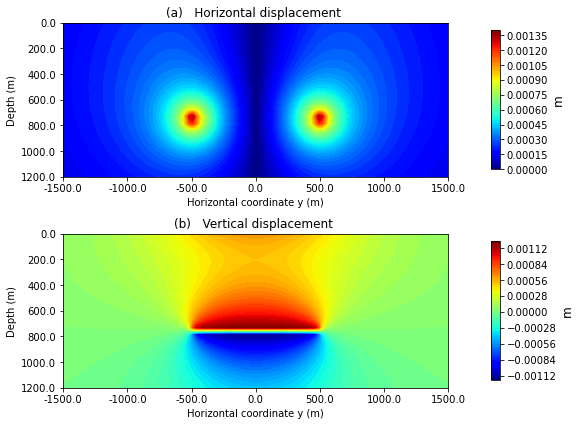

In [30]:
# Plot the displacement fields 
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(12,6))

ax[0].set_aspect("equal")
img = ax[0].contourf(y, z, displacement_horizontal.reshape(shape[::-1]), 
                  60, cmap="jet")
cb = plt.colorbar(img, ax=ax[0], aspect=15, pad=0.05, shrink=0.90)
cb.set_label('m', rotation=90, fontsize=12)
ax[0].set_title("(a)   Horizontal displacement ")

ax[0].set_xticklabels(ax[0].get_xticks())
ax[0].set_yticklabels(ax[0].get_yticks())
ax[0].invert_yaxis()
ax[0].set_xlabel("Horizontal coordinate y (m)")
ax[0].set_ylabel("Depth (m)")

ax[1].set_aspect("equal")
img = ax[1].contourf(y, z, displacement_z.reshape(shape[::-1]),  
                  60, cmap="jet")
cb = plt.colorbar(img, ax=ax[1], aspect=15, pad=0.05, shrink=0.90)
cb.set_label('m', rotation=90, fontsize=12)
ax[1].set_title("(b)   Vertical displacement ")

ax[1].set_xticklabels(ax[1].get_xticks())
ax[1].set_yticklabels(ax[1].get_yticks())
ax[1].invert_yaxis()
ax[1].set_xlabel("Horizontal coordinate y (m)")
ax[1].set_ylabel("Depth (m)")
plt.tight_layout(True)
#plt.savefig('../manuscript/Fig/Figure_Displacement.png', dpi=600)

# Plot the displacement fields by using Geertsma's (1973) nucleus of strain

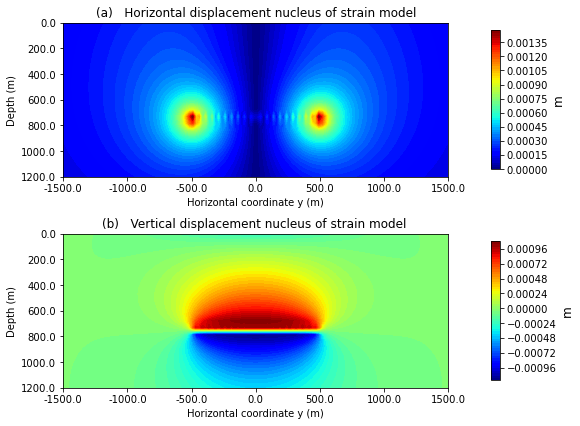

In [31]:
# Plot the displacement fields by using Geertsma's (1973) nucleus of strain
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(12,6))

ax[0].set_aspect("equal")
img = ax[0].contourf(y, z, displacement_horizontal_ns.reshape(shape[::-1]), 
                  60, cmap="jet")
cb = plt.colorbar(img, ax=ax[0], aspect=15, pad=0.05, shrink=0.90)
cb.set_label('m', rotation=90, fontsize=12)
ax[0].set_title("(a)   Horizontal displacement nucleus of strain model")

ax[0].set_xticklabels(ax[0].get_xticks())
ax[0].set_yticklabels(ax[0].get_yticks())
ax[0].invert_yaxis()
ax[0].set_xlabel("Horizontal coordinate y (m)")
ax[0].set_ylabel("Depth (m)")

ax[1].set_aspect("equal")
img = ax[1].contourf(y, z, displacement_z_ns.reshape(shape[::-1]),  
                  60, cmap="jet")
cb = plt.colorbar(img, ax=ax[1], aspect=15, pad=0.05, shrink=0.90)
cb.set_label('m', rotation=90, fontsize=12)
ax[1].set_title("(b)   Vertical displacement nucleus of strain model ")

ax[1].set_xticklabels(ax[1].get_xticks())
ax[1].set_yticklabels(ax[1].get_yticks())
ax[1].invert_yaxis()
ax[1].set_xlabel("Horizontal coordinate y (m)")
ax[1].set_ylabel("Depth (m)")
plt.tight_layout(True)
#plt.savefig('../manuscript/Fig/Figure_Displacement_Nucleus_Strain.png', dpi=600)

# Plot the displacement fields by using Geertsma's (1973) cylinder

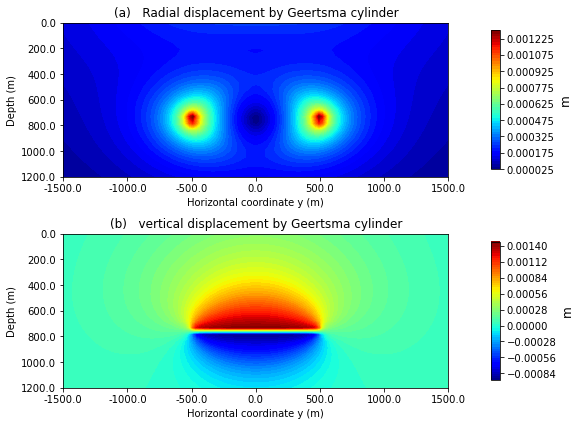

In [32]:
# Plot the displacement fields by Geertsma
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(12,6))

ax[0].set_aspect("equal")
img = ax[0].contourf(y, z, ur.reshape(shape[::-1]), 
                  60, cmap="jet")
cb = plt.colorbar(img, ax=ax[0], aspect=15, pad=0.05, shrink=0.90)
cb.set_label('m', rotation=90, fontsize=12)
ax[0].set_title("(a)   Radial displacement by Geertsma cylinder")

ax[0].set_xticklabels(ax[0].get_xticks())
ax[0].set_yticklabels(ax[0].get_yticks())
ax[0].invert_yaxis()
ax[0].set_xlabel("Horizontal coordinate y (m)")
ax[0].set_ylabel("Depth (m)")

ax[1].set_aspect("equal")
img = ax[1].contourf(y, z, uz.reshape(shape[::-1]),  
                  60, cmap="jet")
cb = plt.colorbar(img, ax=ax[1], aspect=15, pad=0.05, shrink=0.90)
cb.set_label('m', rotation=90, fontsize=12)
ax[1].set_title("(b)   vertical displacement by Geertsma cylinder")

ax[1].set_xticklabels(ax[1].get_xticks())
ax[1].set_yticklabels(ax[1].get_yticks())
ax[1].invert_yaxis()
ax[1].set_xlabel("Horizontal coordinate y (m)")
ax[1].set_ylabel("Depth (m)")
plt.tight_layout(True)
#plt.savefig('../manuscript/Fig/Figure_Displacement_Geertsma.png', dpi=600)

### Differences

In [33]:
#Difference Vertical Displacements Geertsma nucleus of strain and cylinder 
diff_ge = displacement_z_ns - uz

#Difference Vertical Displacement Nagy Geertsma nucleus 
diff_nagy_ns = displacement_z - displacement_z_ns 

diff_nagy_ge = displacement_z - uz


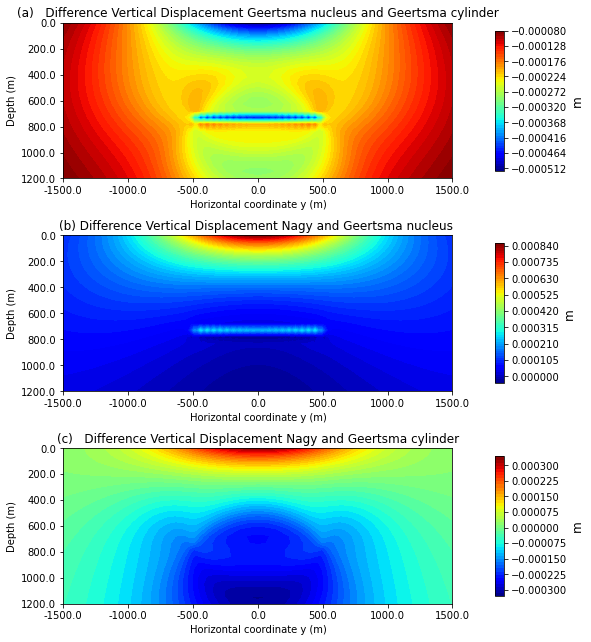

In [34]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=False, sharey=False, figsize=(12,9))

ax[0].set_aspect("equal")
img = ax[0].contourf(y, z, diff_ge.reshape(shape[::-1]), 
                  60, cmap="jet")
cb = plt.colorbar(img, ax=ax[0], aspect=15, pad=0.05, shrink=0.90)
cb.set_label('m', rotation=90, fontsize=12)
ax[0].set_title("(a)   Difference Vertical Displacement Geertsma nucleus and Geertsma cylinder")

ax[0].set_xticklabels(ax[0].get_xticks())
ax[0].set_yticklabels(ax[0].get_yticks())
ax[0].invert_yaxis()
ax[0].set_xlabel("Horizontal coordinate y (m)")
ax[0].set_ylabel("Depth (m)")

ax[1].set_aspect("equal")
img = ax[1].contourf(y, z, diff_nagy_ns.reshape(shape[::-1]),  
                  60, cmap="jet")
cb = plt.colorbar(img, ax=ax[1], aspect=15, pad=0.05, shrink=0.90)
cb.set_label('m', rotation=90, fontsize=12)
ax[1].set_title("(b) Difference Vertical Displacement Nagy and Geertsma nucleus ")

ax[1].set_xticklabels(ax[1].get_xticks())
ax[1].set_yticklabels(ax[1].get_yticks())
ax[1].invert_yaxis()
ax[1].set_xlabel("Horizontal coordinate y (m)")
ax[1].set_ylabel("Depth (m)")

ax[2].set_aspect("equal")
img = ax[2].contourf(y, z, diff_nagy_ge.reshape(shape[::-1]),  
                  60, cmap="jet")
cb = plt.colorbar(img, ax=ax[2], aspect=15, pad=0.05, shrink=0.90)
cb.set_label('m', rotation=90, fontsize=12)
ax[2].set_title("(c)   Difference Vertical Displacement Nagy and Geertsma cylinder")

ax[2].set_xticklabels(ax[2].get_xticks())
ax[2].set_yticklabels(ax[2].get_yticks())
ax[2].invert_yaxis()
ax[2].set_xlabel("Horizontal coordinate y (m)")
ax[2].set_ylabel("Depth (m)")

plt.tight_layout(True)
#plt.savefig('../manuscript/Fig/Figure_Displacement_Geertsma.png', dpi=600)